In [1]:
# Standard library imports
import random
from typing import Type

# Third-party imports
import torch
from torch import Tensor, nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from tqdm.notebook import tqdm_notebook as tqdm

import gym_agent as ga

# Local imports
import utils

pygame 2.5.2 (SDL 2.28.2, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
n_games = 1000
max_t = 1500
n_envs = 1
chkpt_dir = 'checkpoints/BetterCarRacing-v0/CNN_DQN'

env_id = "BetterCarRacing-v0"

seed = 110404

die_if_grass = True

In [3]:
utils.set_random_seed(seed)

Setting seeds ...... 



In [4]:
gym.register(
    id=env_id,
    entry_point="better_car_racing:BetterCarRacing",
    max_episode_steps=max_t,
    reward_threshold=900,
    disable_env_checker=True,
    order_enforce=False
)

In [5]:
class ConvBn(nn.Module):
	'''
	Convolution + BatchNorm + ReLu (+ MaxPool)

	keeping the size of input, if Maxpool, reduce the size by half
	'''
	def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, pool=False) -> None:
		'''
		Convolution + BatchNorm + ReLu (+ MaxPool)

		keeping the size of input, if Maxpool, reduce the size by half
		'''
		super().__init__()
		self.Conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
		self.Bn = nn.BatchNorm2d(out_channels)
		self.act = nn.ReLU(inplace=True)
		
		if pool:
			self.pool = nn.MaxPool2d(2)
		else:
			self.pool = nn.Identity()

	def forward(self, X: Tensor):
		out = self.Conv(X)
		out = self.Bn(out)
		out = self.act(out)
		out = self.pool(out)
		return out

In [6]:
class DeepQNetwork(nn.Module):
    def __init__(self, in_channels: int, n_vector: int, n_actions: int, filters: list[int] = [16, 32, 64], fc: list[int] = [256]) -> None:
        super().__init__()

        self.initial = ConvBn(in_channels, filters[0], 8, 4, 2)

        self.conv = nn.Sequential()

        for i in range(len(filters)-1):
            self.conv.append(ConvBn(filters[i], filters[i+1], pool=True))
        
        self.conv.append(nn.AdaptiveMaxPool2d((4, 4)))

        self.conv.append(nn.Flatten())

        self.fcs = nn.Sequential(
            nn.Linear(4*4*filters[-1] + n_vector, fc[0]),
            nn.ReLU(),
            nn.Linear(fc[0], n_actions)
        )

    def forward(self, state: dict[str, torch.Tensor]) -> torch.Tensor:
        image = state['image']
        vector = state['vector']

        image_encoded = self.initial(image)
        image_encoded = self.conv(image_encoded)

        inp_vector = torch.cat([image_encoded, vector], dim=1)

        return self.fcs(inp_vector)

In [7]:
class Policy(nn.Module):
    def __init__(self, in_channels: int, n_vector: int, n_actions: int, filters: list[int], fcs: list[int], optimizer: Type[optim.Optimizer] = optim.Adam, lr: float = 5e-4, optimizer_kwargs: dict = None):
        super().__init__()
        self.network = DeepQNetwork(in_channels, n_vector, n_actions, filters, fcs)
        self.target_network = DeepQNetwork(in_channels, n_vector, n_actions, filters, fcs)
        self.soft_update(tau=1)

        if optimizer_kwargs is None:
            optimizer_kwargs = {}
        
        self.optimizer = optimizer(self.network.parameters(), lr=lr, **optimizer_kwargs)

    def forward(self, state: dict[str, torch.Tensor]) -> torch.Tensor:
        return self.network(state)

    def target_forward(self, state: dict[str, torch.Tensor]) -> torch.Tensor:
        return self.target_network(state)

    def soft_update(self, tau: float):
        for target_param, param in zip(self.target_network.parameters(), self.network.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

In [8]:
class CNN_DQN(ga.OffPolicyAgent):
    policy: Policy
    def __init__(
            self, 
            policy, 
            env,    
            action_space,
            gamma = 0.99,
            eps_start = 1.0,
            eps_decay = 0.995,
            eps_end = 0.01,
            tau = 1e-3,
            batch_size = 64, 
            buffer_size = int(1e4),
            update_every = 1, 
            device='auto', 
            seed=None
        ):

        super().__init__(policy, env, buffer_size=buffer_size, batch_size=batch_size, update_every=update_every, device=device, seed=seed)

        self.action_space = action_space

        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.eps_end = eps_end

        # Soft update parameter
        self.tau = tau


        # Initialize epsilon for epsilon-greedy policy
        self.eps = eps_start

        self.add_optimizer('policy', self.policy.optimizer)
        self.add_save_kwargs('eps')

    def reset(self):
        self.eps = max(self.eps_end, self.eps_decay * self.eps)

    @torch.no_grad()
    def predict(self, state: dict[str, np.ndarray], deterministic = True) -> int:
        # Determine epsilon value based on evaluation mode
        if deterministic:
            eps = 0
        else:
            eps = self.eps

        # Epsilon-greedy action selection
        if random.random() >= eps:

            _state = {}

            for key, value in state.items():
                _state[key] = torch.from_numpy(value).float().to(self.device)

            # Set local model to evaluation mode
            self.policy.eval()
            # Get action values from the local model
            action_value = self.policy.forward(_state)
            # Set local model back to training mode
            self.policy.train()

            # Return the action with the highest value
            return np.argmax(action_value.cpu().data.numpy(), axis=1)
        else:
            # Return a random action from the action space
            return [random.choice(self.action_space) for _ in range(state['image'].shape[0])]

    def learn(self, states: dict[str, Tensor], actions: Tensor, rewards: Tensor, next_states: Tensor, terminals: Tensor):
        """
        Update the value network using a batch of experience tuples.

        Params
        ======
            states (Tensor): Batch of current states
            actions (Tensor): Batch of actions taken
            rewards (Tensor): Batch of rewards received
            next_states (Tensor): Batch of next states
            terminals (Tensor): Batch of terminal flags indicating episode end
        """

        # Get the maximum predicted Q values for the next states from the target model
        q_targets_next = self.policy.target_forward(next_states).detach().max(1)[0]
        # Compute the Q targets for the current states
        q_targets = rewards + (self.gamma * q_targets_next * (~terminals))

        # Get the expected Q values from the local model
        q_expected = self.policy.forward(states)

        q_expected = q_expected.gather(1, actions.long()).squeeze(1)

        # Compute the loss
        loss = F.smooth_l1_loss(q_expected, q_targets)

        # Minimize the loss
        self.policy.optimizer.zero_grad()
        loss.backward()
        self.policy.optimizer.step()

        # Update the target network
        self.soft_update()

    def soft_update(self, tau = None):
        if tau is None:
            tau = self.tau

        self.policy.soft_update(tau)

### Transform

In [9]:
class StateTfm(ga.Transform):
    def __init__(self, n_frame=4):
        super().__init__()

        self.observation_space = gym.spaces.Dict({
            'image': gym.spaces.Box(low=0, high=1, shape=(n_frame, 96, 96), dtype=np.float32),
            'vector': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(7, ), dtype=np.float32),
        })

        self.n_frame = n_frame

        self.frames = {'image': np.zeros((self.n_frame, 96, 96), dtype=np.float32), 'vector': np.zeros((7, ), dtype=np.float32)}

        self.start = False

    def __call__(self, observation: dict[str, np.ndarray]) -> np.ndarray:
        image = observation['image'].astype(np.float32).transpose([2, 0, 1]) # n_envs, 3, 96, 96
        r, g, b = image[0], image[1], image[1]
        gray_image = 0.2989 * r + 0.5870 * g + 0.1140 * b

        vels = observation['vels'].astype(np.float32)
        # res = np.concatenate([rays, vels], axis=-1)

        if self.start:
            self.frames['image'][0] = gray_image
            self.frames['image'] = np.roll(self.frames['image'], shift=-1, axis=0)
            
        else:
            for i in range(self.n_frame):
                self.frames['image'][i] = gray_image

        self.frames['vector'] = vels

        self.start = True

        return self.frames

    def reset(self, **kwargs):
        self.frames = {'image': np.zeros((self.n_frame, 96, 96), dtype=np.float32), 'vector': np.zeros((7, ), dtype=np.float32)}

        self.start = False

In [10]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        for _ in range(self._skip):
            if self.unwrapped.render_mode == 'human':
                self.unwrapped.render()
            state, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward
            if terminated:
                break
        return state, total_reward, terminated, truncated, info

### train

In [11]:
env = ga.make(env_id, observation_transform=StateTfm(), continuous=False, die_if_grass = die_if_grass)

In [12]:
env.add_wrapper(SkipFrame, skip=4)

In [13]:
agent = CNN_DQN(
    policy = Policy(4, 7, 5, filters=[16, 32, 64], fcs=[256]).apply(utils.init_weights('kaiming')),
    env = env,
    action_space = list(range(5)),
    gamma=0.99,
    eps_start=1.0,
    eps_decay=0.995,
    eps_end=0.01,
    tau=1e-3,
    batch_size=64,
    update_every=4,
    device='auto',
    seed=seed
).to('cuda')


In [14]:
agent.load(chkpt_dir, 'best')

In [15]:
agent.fit(n_games=2000, deterministic=False, save_best=True, save_every=100, save_dir=chkpt_dir, progress_bar=tqdm)

  0%|          | 0/1008 [00:00<?, ?it/s]

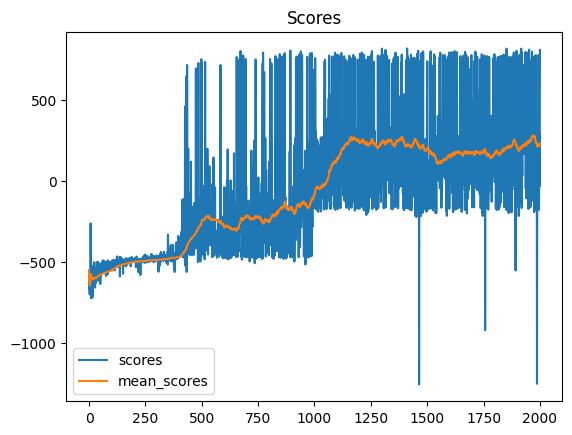

In [16]:
agent.plot_scores()

In [62]:
env = ga.make(env_id, render_mode = 'human', observation_transform=StateTfm(), continuous=False, die_if_grass = True, lap_complete_percent = 1)
env.add_wrapper(SkipFrame, skip=4)
agent.load(chkpt_dir, "best")
agent.play(env, stop_if_truncated=True)

800.0000000000042

In [ ]:
agent.load(chkpt_dir, "best")
import pygame

pygame.init()
score = 0
obs = env.reset(seed=seed)[0]
agent.reset()

done = False
while not done:
    env.render()
    action = agent.predict({'image': np.expand_dims(obs['image'], 0), 'vector': np.expand_dims(obs['vector'], 0)}, True)
    print(action)
    next_obs, reward, terminated, truncated, info = env.step(action[0])

    done = terminated

    done = done or truncated

    obs = next_obs

    score += env.env_reward

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            done = True

pygame.quit()


In [8]:
obs = env.reset()[0]

In [9]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(env.render())
plt.savefig("test.png")